In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [3]:
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def run_functions(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    columns = ["Age_categories", "Fare_categories", "Title", "Cabin_type", "Sex"]
    for col in columns:
        df = create_dummies(df, col)
        
    return df

In [5]:
train = run_functions(train)
holdout = run_functions(holdout)

In [6]:
print(holdout.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Embarked    ...    Cabin_type_A  \
0  34.5      0      0   330911   7.8292        Q    ...               0   
1  47.0      1      0   363272   7.0000        S    ...               0   
2  62.0      0      0   240276   9.6875        Q    ...               0   
3  27.0      0      0   315154   8.6625        S    ...               0   
4  22.0      1      1  3101298  12.2875        S    ...               0   

  Cabin_type_B Cabin_type_C Cabin_type_D  Cabin_type_E  Cabin_type_F

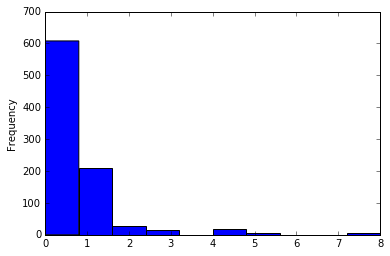

In [7]:
train["SibSp"].plot.hist()

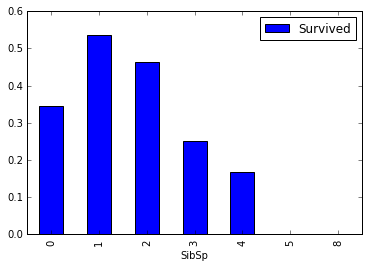

In [8]:
train.pivot_table(index="SibSp",values="Survived").plot.bar()

If you had 1-2 siblings or spouse you had a greater rate of survival then if you came alone or if you had greater than 2 siblings. 

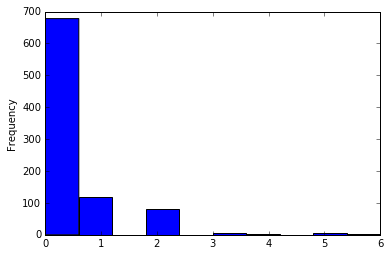

In [9]:
train["Parch"].plot.hist()

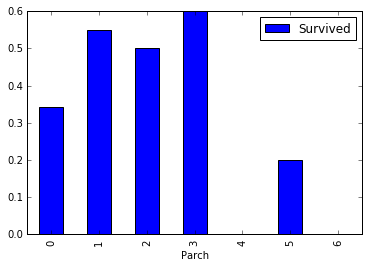

In [10]:
train.pivot_table(index="Parch",values="Survived").plot.bar()

In [11]:
sib_parch = train.pivot_table(index=["SibSp", "Parch"],values="Survived")

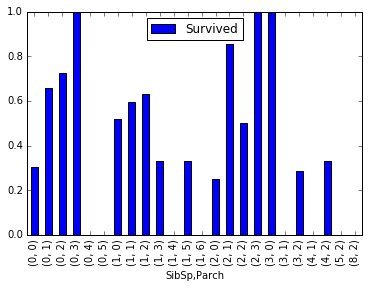

In [12]:
sib_parch.plot.bar()

In [13]:
def  process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    return df

In [14]:
train = process_isalone(train)
holdout = process_isalone(holdout)

In [15]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [16]:
def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["PassengerId", "Survived"], axis=1)
    all_y = df["Survived"]
    model = RandomForestClassifier(random_state=1)
    selector = RFECV(model, cv=10)
    selector.fit(all_X, all_y)
    best_columns = all_X.columns[selector.support_]
    print(best_columns)
    return best_columns
    

In [17]:
best_columns = select_features(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [19]:
def select_model(df, features):
    all_X = df[features]
    all_y = df["Survived"]
    best_model = dict()
    model_list = [{
        "name": "LogisticRegression",
        "estimator": LogisticRegression(),
        "hyperparameters": {
            "solver": ["newton-cg", "lbfgs", "liblinear"]
        }
    }, {
        "name": "RandomForestClassifier",
        "estimator": RandomForestClassifier(),
        "hyperparameters": {
            "n_estimators": [4, 6, 9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
        }
    }, {
        "name": "KNeighborsClassifier",
        "estimator": KNeighborsClassifier(),
        "hyperparameters": {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }
    }]
    
    for model in model_list:
        print(model["name"])
        grid = GridSearchCV(model["estimator"], param_grid=model["hyperparameters"], cv=10)
        grid.fit(all_X, all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        
        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))
        
    return model_list
        

In [ ]:
model_list = select_model(train, best_columns)

LogisticRegression
Best Score: 0.8204264870931538
Best Parameters: {'solver': 'liblinear'}

RandomForestClassifier
Best Score: 0.8428731762065096
Best Parameters: {'n_estimators': 4, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 3}

KNeighborsClassifier


In [53]:
def save_submission_file(model, features, filename="submission.csv"):
    predictions = model.predict(holdout[features])
    submission_df = {"PassengerId": holdout["PassengerId"],
                     "Survived": predictions}
    submission = pd.Dataframe(submission_df)
    submission.to_csv(filename, index=False)

In [ ]:
model = model_list[1]["best_model"]
save_submission_file(model, best_columns)